# Page Detection
This code finds and crops the page out of the image

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

sys.path.append('../src')
from ocr.helpers import implt, resize, ratio

%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0, 9.0)

### Global Variables

In [3]:
IMG = "page09"    # Image name/number

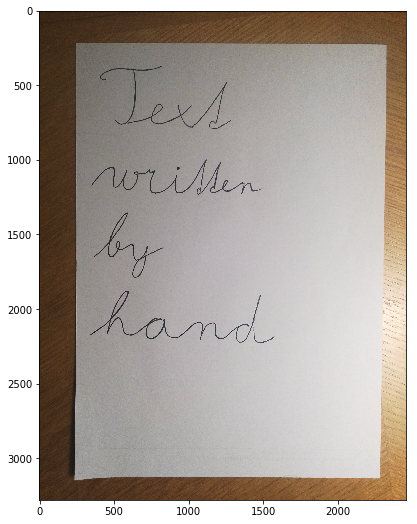

In [4]:
# Loading images and ploting it (converting to RGB from BGR)
image = cv2.cvtColor(cv2.imread("../data/pages/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

In [5]:
def edges_det(img, min_val, max_val):
    """ Preprocessing (gray, thresh, filter, border) + Canny edge detection """
    img = cv2.cvtColor(resize(img), cv2.COLOR_BGR2GRAY)

    # Applying blur and threshold
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    implt(img, 'gray', 'Adaptive Threshold')

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    # Contour can't touch side of image
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    implt(img, 'gray', 'Median Blur + Border')

    return cv2.Canny(img, min_val, max_val)

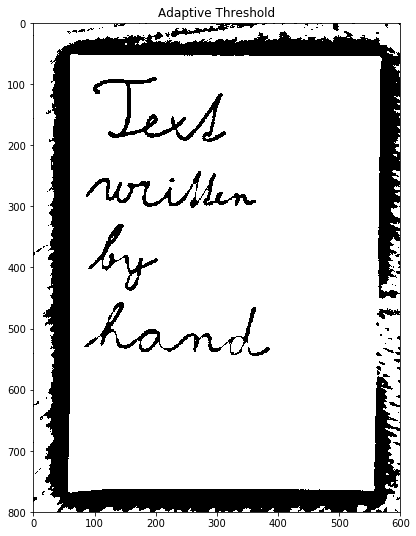

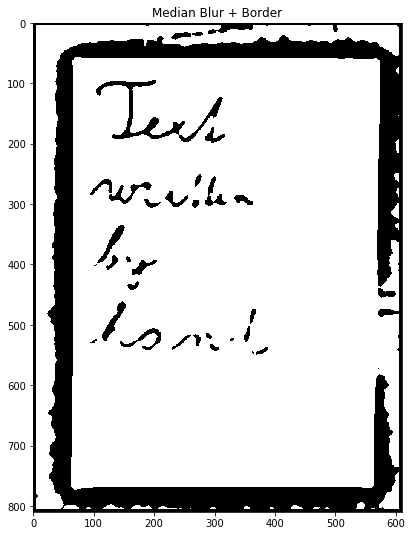

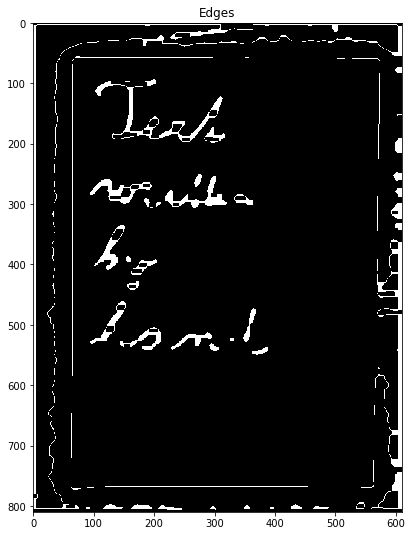

In [6]:
# Edge detection ()
edges_image = edges_det(image, 200, 250)

# Close gaps between edges (double page clouse => rectangle kernel)
edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))
implt(edges_image, 'gray', 'Edges')

In [7]:
def four_corners_sort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right"""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contour_offset(cnt, offset):
    """ Offset contour because of 5px border """
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def find_page_contours(edges, img):
    """ Finding corner points of page contour """
    # Getting contours  
    im2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                            [0, height-5],
                            [width-5, height-5],
                            [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = four_corners_sort(page_contour)
    return contour_offset(page_contour, (-5, -5))

PAGE CONTOUR:
[[ 63  54]
 [ 57 762]
 [554 764]
 [568  59]]


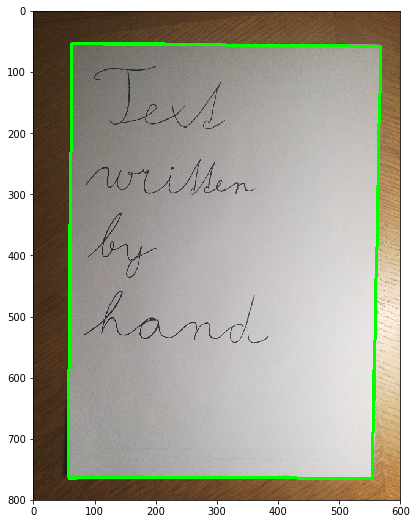

In [8]:
page_contour = find_page_contours(edges_image, resize(image))
print("PAGE CONTOUR:")
print(page_contour)
implt(cv2.drawContours(resize(image), [page_contour], -1, (0, 255, 0), 3))

       
# Recalculate to original scale
page_contour = page_contour.dot(ratio(image))

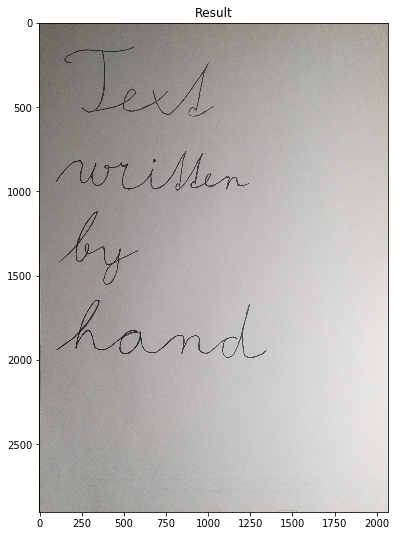

In [9]:
def persp_transform(img, s_points):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = persp_transform(image, page_contour)
implt(newImage, t='Result')